__Subject:__ Topics of Tweets of US Congress through the Lens of Campaign Finance

__Date:__ 09/10/2018

__Name:__ Edmund D. Chitwood
***

__Summary:__<br>
<br>The following Notebook 
- reads Tweets of all Congress Members into a Pandas DataFrame,
- performs EDA,
- cleans them,
- preprocceses them in preparation for topic modeling.

# Read in Data and EDA

In [1]:
import pandas as pd
import nltk
import pickle

In [2]:
tweets = pd.read_pickle('congress_tweets.pkl')

In [7]:
# Dataset includes 1.8 million Tweets
tweets.shape

(1852507, 9)

In [8]:
tweets.describe()

,retweets,favorites,id
count,1.852507e+06,1.852507e+06,1.852507e+06
mean,7.488233e+01,1.814578e+02,6.145035e+17
std,9.643075e+02,2.401487e+03,2.937498e+17
min,0.000000e+00,0.000000e+00,4.452310e+08
25%,1.000000e+00,0.000000e+00,3.901738e+17
50%,3.000000e+00,3.000000e+00,6.601509e+17
75%,1.000000e+01,1.700000e+01,8.681510e+17
max,4.369710e+05,9.486740e+05,1.038613e+18


In [9]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852507 entries, 0 to 8768
Data columns (total 9 columns):
username     object
date         object
retweets     int64
favorites    int64
text         object
mentions     object
hashtags     object
id           int64
permalink    object
dtypes: int64(3), object(6)
memory usage: 141.3+ MB


In [10]:
for tweet in tweets['text'][100000:100005]:
    print(tweet, '\n')

Thx @marklevinshow https:// twitter.com/foxnews/status /970503582595338240 … 

Looking forward to being with @marklevinshow on his new Fox News show! Much better than Oscars! https:// twitter.com/marklevinshow/ status/970471715930345473 … 

My daughter sees @TuckerCarlson report on TV saying California is becoming 3rd world and asks me why. I tell her CA has highest taxes in USA that make it hard for people to afford to live here. She responds “Don’t you get paid to fix it?” 

Congrats! Media hacks win award for Fakenews! https://www. washingtontimes.com/news/2018/mar/ 1/fbi-debunked-russia-trump-story-helped-new-york-ti/ … 

Must read by @NRO ...nothing more needs to be said unless you’re a Russian Bot... https://www. nationalreview.com/2018/02/schiff -memo-russia-investigation-harms-democrats-more-than-helps-them/ … 



In [11]:
for tweet in tweets['username'][100000:100005]:
    print(tweet, '\n')

DevinNunes 

DevinNunes 

DevinNunes 

DevinNunes 

DevinNunes 



In [12]:
# Convert Tweet objects to strings
tweets['text']  = tweets['text'].apply(lambda x: str(x)) 

In [13]:
# Get number of characters in each Tweet
tweets['length'] = tweets['text'].apply( lambda x: len(x))

In [14]:
tweets.describe()

,retweets,favorites,id,length
count,1.852507e+06,1.852507e+06,1.852507e+06,1.852507e+06
mean,7.488233e+01,1.814578e+02,6.145035e+17,1.483871e+02
std,9.643075e+02,2.401487e+03,2.937498e+17,5.893152e+01
min,0.000000e+00,0.000000e+00,4.452310e+08,1.000000e+00
25%,1.000000e+00,0.000000e+00,3.901738e+17,1.190000e+02
50%,3.000000e+00,3.000000e+00,6.601509e+17,1.380000e+02
75%,1.000000e+01,1.700000e+01,8.681510e+17,1.640000e+02
max,4.369710e+05,9.486740e+05,1.038613e+18,1.254000e+03


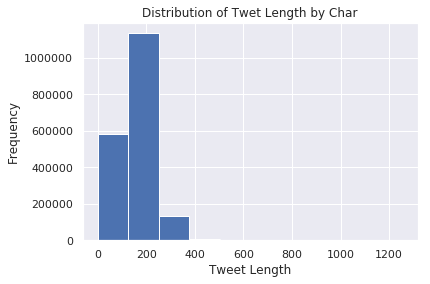

In [16]:
# Import seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# Create a histogram of all Tweet lengths
ax = tweets.length.hist(bins=20)
ax.set(xlabel='Tweet Length', ylabel='Frequency', 
       title='Distribution of Tweet Length by Char');

In [18]:
# Shortest tweets are single chars
tweets.sort_values(by='length',ascending=True).iloc[0:5]['text']

1357    X
4116    E
5811    z
1504    #
5551    Q
Name: text, dtype: object

In [17]:
# Tweets are accessible via permalinks
tweets.sort_values(by='length',ascending=False).iloc[1]['permalink']

'https://twitter.com/PeteSessions/status/869267749779808256'

In [20]:
# Most Retweeted Tweet is by Senator Bernie Sanders
tweets.sort_values(by='retweets',ascending=False).iloc[0]['text']

'President Trump, you made a big mistake. By trying to divide us up by race, religion, gender and nationality you actually brought us closer. pic.twitter.com/U7deCCTFx9'

#  Data Cleaning

In [21]:
# Drop tweets that are too short and may not contain much meaning
tweets.drop(tweets[tweets['length']<20].index, inplace=True)


In [22]:
from datetime import datetime
from dateutil.parser import parse
import pandas as pd


In [23]:
# Parse date strings
tweets.date = tweets.date.apply(lambda x : pd.to_datetime(parse(x)))

In [24]:
tweets['year'] = tweets.date.apply(lambda x: x.year)

In [25]:
# Dataset includes Tweets from every year, dating back to 2007
tweets.year.value_counts()

2013    118846
2015    114652
2017    112912
2014    107984
2016    100778
2012     77780
2011     70979
2018     59708
2010     30139
2009     14775
2008       439
2007         2
Name: year, dtype: int64

# Natural Language Processing

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
# add custom stop words
more_stops =(['ive', 'isnt', 'theres', 'doesnt', 'wont', 'im', \
              'dont','youre', 'weve',  'theyre', 'around', 'thats',\
              'heres','hasnt','cant','sanderssenategovnewsroomnewsw'])             

In [47]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re

def custom_tokenizer(text):
    
    # remove urls
    text = re.sub(r'http[s]?\:\/\/[\S\s]\S+', '', text)

    # remove mentions (@username)
    text = re.sub(r'\@[a-zA-Z1-9]+', '', text)
    
    # remove hashtags (#tag)
    text = re.sub(r'\#[a-zA-Z1-9]+', '', text)

    # remove punctuation
    full_punc = '’‘“”.–…�★➠—' + string.punctuation
    remove_punct = str.maketrans('', '', full_punc)
    text = text.translate(remove_punct)


    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = stopwords.words('english')
    stop_words = stop_words + more_stops
    tokens_stop = [y for y in tokens if y not in stop_words]

    # stem
    stemmer = nltk.stem.porter.PorterStemmer(mode='NLTK_EXTENSIONS')
    tokens_stem = [stemmer.stem(y) for y in tokens_stop] 

    return tokens_stem

In [48]:
tweets['tokens'] = tweets.text.apply(lambda x :custom_tokenizer(x))

In [49]:
# Compare full Tweets to preprocessed Tweets
for tweet in tweets['text'][len(tweets)-5:len(tweets)]:
    print(tweet, '\n')

On this day, we celebrate the ability of American women to participate freely in public life, but the fight for full equality hasn't ended. 

The Sunshine State needs a governor with real-world experience who can get the state’s economy back on track. Alex Sink is that leader. 

Kendrick Meek waged a fierce campaign on behalf of all Floridians. I congratulate him on this win and look forward to working with him. 

I served as a missionary in a country without voting rights—an experience that taught me to cherish the right to vote. #whyivote 

Voting is the right that safeguards all of our other rights. #whyivote 



In [50]:
for tweet in tweets['tokens'][len(tweets)-5:len(tweets)]:
    print(tweet, '\n')

['day', 'celebr', 'abil', 'american', 'women', 'particip', 'freeli', 'public', 'life', 'fight', 'full', 'equal', 'end'] 

['sunshin', 'state', 'need', 'governor', 'realworld', 'experi', 'get', 'state', 'economi', 'back', 'track', 'alex', 'sink', 'leader'] 

['kendrick', 'meek', 'wage', 'fierc', 'campaign', 'behalf', 'floridian', 'congratul', 'win', 'look', 'forward', 'work'] 

['serv', 'missionari', 'countri', 'without', 'vote', 'rightsan', 'experi', 'taught', 'cherish', 'right', 'vote'] 

['vote', 'right', 'safeguard', 'right'] 



In [51]:
tweets.head()

,username,date,retweets,favorites,text,mentions,hashtags,id,permalink,length,year,tokens
0,AnthonyBrownMD4,2018-09-07 17:31:08,6,12,"Last night, @realDonaldTrump attacked Maryland...",@realDonaldTrump @BenJealous,#Dreamers,1038117477622992900,https://twitter.com/AnthonyBrownMD4/status/103...,299,2018,"[last, night, attack, maryland, valu, go, immi..."
2,AnthonyBrownMD4,2018-08-19 18:29:15,1,3,The Maryland 4th Congressional District Office...,NaN,NaN,1031246733114662912,https://twitter.com/AnthonyBrownMD4/status/103...,301,2018,"[maryland, th, congression, district, offic, s..."
3,AnthonyBrownMD4,2018-05-23 18:11:56,1,1,Congratulations @AmyMcGrathKY,@AmyMcGrathKY,NaN,999352242829438983,https://twitter.com/AnthonyBrownMD4/status/999...,29,2018,[congratul]
6,AnthonyBrownMD4,2018-04-14 12:29:37,3,11,Mission Accomplished? Not so easy Mr. Presiden...,NaN,NaN,985132970746044416,https://twitter.com/AnthonyBrownMD4/status/985...,279,2018,"[mission, accomplish, easi, mr, presid, missio..."
8,AnthonyBrownMD4,2018-03-17 03:46:08,4,23,First 16th seed men’s basketball team to beat ...,NaN,#1,974854369169563648,https://twitter.com/AnthonyBrownMD4/status/974...,93,2018,"[first, th, seed, men, basketbal, team, beat, ..."


In [52]:
# Join stems to create strings to be used with Count Vectorizer
tweets['clean_text'] = tweets.tokens.apply(lambda x: ' '.join(x))

In [54]:
tweets.to_pickle('preprocessed_tweets.pkl')